<a href="https://colab.research.google.com/github/crd3cc04/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_214_module4-logistic-regression/_Cortesha_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [7]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
# Preperation of spliting the data into train/validate/test
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(df['Date'])
df = df.sort_index()
df

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,2011-05-16,NaN,NaN,NaN,8.00,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,NaN,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2015-04-20,Other,2015-04-20,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2016-01-18,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,Asada,2019-08-27,NaN,NaN,NaN,6.75,3.0,NaN,NaN,19.00,25.0,0.94,3.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-27,Other,2019-08-27,NaN,NaN,NaN,5.50,2.0,NaN,NaN,19.00,23.0,0.80,4.5,5.0,5.0,3.5,4.0,4.5,4.0,4.9,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-27,Other,2019-08-27,NaN,NaN,NaN,6.00,3.0,NaN,NaN,17.50,21.5,0.64,4.0,4.0,4.5,4.0,3.0,3.0,4.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [10]:
train = df[:'2017-01-01']
val = df['2017-01-01':'2017-12-01']
test  = df['2018-01-01':]
print('Train Dataset:',train.shape)
print('Validation Dataset', val.shape)
print('Test Dataset:',test.shape)

Train Dataset: (298, 59)
Validation Dataset (82, 59)
Test Dataset: (38, 59)


In [0]:
from sklearn.model_selection import train_test_split

In [12]:
x = train.drop(columns=['Great'])
y = train.Great

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size=0.25,
                                                  stratify=y,
                                                  random_state=42)
print(x_train.shape, x_val.shape)

(223, 58) (75, 58)


In [13]:
# Determining majority class baseline from each dataset
y_train.value_counts(normalize=True)

False    0.591928
True     0.408072
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [15]:
# The baseline accuracy if we guessed the majority class for every prediction
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)


0.5919282511210763

In [16]:
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5866666666666667

In [17]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [19]:
# Using skcikit-learn for Logistic Regression..... to get the Validation Accuracy
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

target = 'Great'
features = ['Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
print(X_train.shape, X_val.shape)

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
print(X_train_encoded.shape, X_val_encoded.shape)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))


(298, 11) (82, 11)
(298, 11) (82, 11)
Validation Accuracy 0.8536585365853658


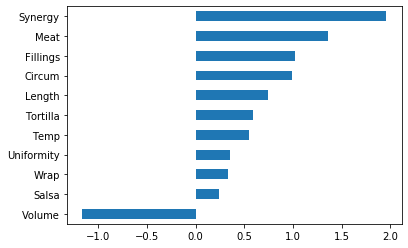

In [20]:
# Plotting coefficients
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [22]:
# Getting the test accuracy.....
test.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,3.000000,3.000000,38.000000,38.000000,0.0,0.0,34.000000,33.000000,33.000000,38.000000,38.000000,36.000000,37.000000,37.000000,38.000000,35.000000,38.000000,37.000000,0.0
mean,3.833333,3.966667,7.240263,3.484211,NaN,NaN,19.899706,22.378788,0.794242,3.876316,4.157895,3.947222,3.732432,3.827027,3.552632,3.651429,3.755263,3.891892,NaN
std,0.577350,0.288675,1.362778,0.849014,NaN,NaN,2.270937,1.644072,0.144850,0.791999,0.959344,0.707303,0.699625,1.047921,1.158223,0.796452,0.798207,1.202631,NaN
min,3.500000,3.800000,4.190000,1.000000,NaN,NaN,17.000000,19.000000,0.520000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,NaN
25%,3.500000,3.800000,5.990000,3.000000,NaN,NaN,18.000000,21.500000,0.680000,3.500000,4.000000,3.500000,3.000000,3.200000,3.000000,3.000000,3.000000,3.000000,NaN
50%,3.500000,3.800000,7.320000,3.500000,NaN,NaN,19.500000,22.000000,0.770000,4.000000,4.500000,4.000000,3.700000,4.000000,4.000000,4.000000,4.000000,4.000000,NaN
75%,4.000000,4.050000,8.000000,4.000000,NaN,NaN,21.375000,23.500000,0.910000,4.500000,5.000000,4.500000,4.000000,4.500000,4.225000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.300000,9.990000,5.000000,NaN,NaN,25.000000,26.000000,1.070000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [23]:
target = 'Great'
features = ['Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
print(X_train.shape, X_test.shape)

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
print(X_train_encoded.shape, X_test_encoded.shape)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
print('Test Accuracy', model.score(X_test_scaled, y_test))


(298, 11) (38, 11)
(298, 11) (38, 11)
Test Accuracy 0.7631578947368421
